# Optical Character Recognition with Convolutional Neural Network
---
+ OCR with CNN

+ Dataset: "[The Chars74K dataset](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/)"

+ CNN model <br>
<br>
<img src="https://i.imgur.com/4qQWzLk.png" width="750" height="350"/>
 

importing libraries
---
+ tensorflow, keras, opencv, numpy, matplotlib, imutils

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
from cv2 import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imutils
from imutils.contours import sort_contours
from sklearn.metrics import classification_report, confusion_matrix

Hyperparameters
---
+ batch size
+ input layer images height and width
+ learning rate

In [2]:
#hyperparameters
batch_size = 64
learning_rate = 1e-3
img_height = 32
img_width = 32

Loading the data set
---
+ ./data/train/
    + Sample001
        + img001-00001.png
        <br />...
    + Sample002
        + img002-00001.png
        <br />...
    + Sample003
        + img003-00001.png
        <br />... 
    + .
    <br />.
    <br />.

In [3]:
# load and iterate training dataset
trainData = keras.preprocessing.image_dataset_from_directory(
    directory= './data/Chars74k/GoodImag',
    labels= 'inferred',
    label_mode= 'categorical',
    batch_size= batch_size,
    image_size= (img_height, img_width),
    color_mode='grayscale',
    validation_split= 0.2,
    subset= 'training',
    seed=123,
    )

testData = tf.keras.preprocessing.image_dataset_from_directory(
    directory= './data/Chars74k/GoodImag',
    labels= 'inferred',
    label_mode= 'categorical',
    batch_size= batch_size,
    image_size= (img_height, img_width),
    color_mode='grayscale',
    validation_split= 0.2,
    subset= 'validation',
    seed=123
    )

Found 7705 files belonging to 62 classes.
Using 6164 files for training.
Found 7705 files belonging to 62 classes.
Using 1541 files for validation.


Information about the data set
---
+ Class Names
+ Sample images

In [4]:
class_names = trainData.class_names
class_names =  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
print(f"Data set's class names: \n {class_names}")
num_class = len(class_names)
print(f"Class count: {num_class}")

for image_batch, labels_batch in trainData:
  print("image_batch.shape >>",image_batch.shape)
  print("image_labels.shape >>",labels_batch.shape)
  break

Data set's class names: 
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Class count: 62
image_batch.shape >> (64, 32, 32, 1)
image_labels.shape >> (64, 62)


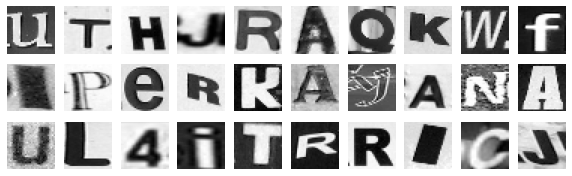

In [5]:
plt.figure(figsize=(10, 3))
for images, labels in trainData.take(1):
  for i in range(30):
    ax = plt.subplot(3, 10, i + 1)
    plt.imshow(images[i].numpy().astype("float"),cmap='gray')
    plt.axis("off")

Standardize the data
---
+ The RGB channel values are in the 0, 255 range. This is not ideal for a neural network; in general you should seek to make your input values small. 

In [6]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

trainData = trainData.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(trainData))
# Notice the pixels values are now in `[0,1]`.


testData = testData.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(testData))

first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.18103172 0.7724725


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

trainData = trainData.cache().prefetch(buffer_size=AUTOTUNE)
testData = testData.cache().prefetch(buffer_size=AUTOTUNE)

Train a model
---


In [8]:
model = tf.keras.Sequential([
    layers.Conv2D(64, (7,7), use_bias=False, input_shape=(img_width,img_height,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3,3),padding='same'),
    layers.Conv2D(128, (3,3), use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(padding='same'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_class, activation='softmax')
])

In [9]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True
    )

model.compile(
  optimizer= Adam(learning_rate=learning_rate),
  loss='categorical_crossentropy',
  metrics=['accuracy']
  )

In [10]:
with tf.device('/GPU:0'):
    history = model.fit(
        trainData,
        epochs=100,
        callbacks = [callback],
        validation_data=(testData)
       )

Epoch 1/100
97/97 [==============================] - 68s 630ms/step - loss: 3.8141 - accuracy: 0.1156 - val_loss: 3.7040 - val_accuracy: 0.1168
Epoch 2/100
97/97 [==============================] - 1s 10ms/step - loss: 2.7434 - accuracy: 0.3206 - val_loss: 3.3138 - val_accuracy: 0.1369
Epoch 3/100
97/97 [==============================] - 1s 10ms/step - loss: 2.1409 - accuracy: 0.4283 - val_loss: 2.2899 - val_accuracy: 0.3816
Epoch 4/100
97/97 [==============================] - 1s 10ms/step - loss: 1.8364 - accuracy: 0.4862 - val_loss: 1.5674 - val_accuracy: 0.5834
Epoch 5/100
97/97 [==============================] - 1s 10ms/step - loss: 1.6592 - accuracy: 0.5253 - val_loss: 1.3372 - val_accuracy: 0.6119
Epoch 6/100
97/97 [==============================] - 1s 10ms/step - loss: 1.4937 - accuracy: 0.5704 - val_loss: 1.2584 - val_accuracy: 0.6457
Epoch 7/100
97/97 [==============================] - 1s 10ms/step - loss: 1.4646 - accuracy: 0.5838 - val_loss: 1.2483 - val_accuracy: 0.6366
Epoc

In [ ]:
#saving weights
model.save('./weight/good2.h5')

In [ ]:
#loading weights
model = tf.keras.models.load_model('./weight/good2.h5')

Model analysis
---
+ Model summary
+ Accuracy plot
+ Loss func. plot
+ classification_report (f score, recall)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73728     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 128)         0

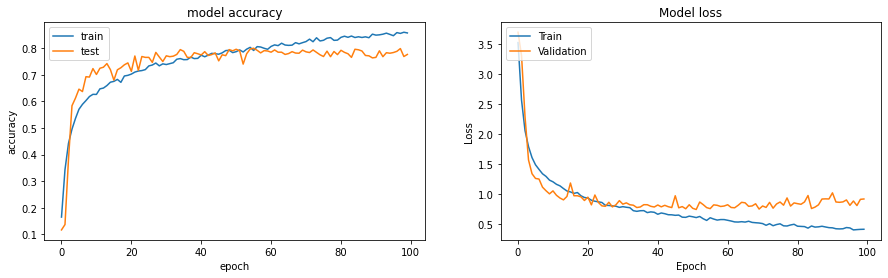

In [12]:
plt.figure(figsize=(15, 4))
plt.subplot(121),
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
y_pred = model.predict(testData)

predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = tf.concat([y for x, y in testData], axis=0)
true_categories = tf.argmax(true_categories, axis=1)

report = classification_report(true_categories, predicted_categories, target_names= class_names, output_dict=True)
print(pd.DataFrame(report).transpose())

              precision    recall  f1-score      support
0              0.410256  0.592593  0.484848    27.000000
1              0.571429  0.727273  0.640000    11.000000
2              1.000000  0.600000  0.750000    10.000000
3              0.888889  0.615385  0.727273    13.000000
4              1.000000  0.666667  0.800000     6.000000
...                 ...       ...       ...          ...
y              0.625000  0.555556  0.588235     9.000000
z              0.500000  0.166667  0.250000     6.000000
accuracy       0.776119  0.776119  0.776119     0.776119
macro avg      0.729734  0.669601  0.671078  1541.000000
weighted avg   0.788664  0.776119  0.767820  1541.000000

[65 rows x 4 columns]


---
---

OCR
---
+ Letter detect on images <br>
    + otsu_threshold <br>

    <img src="https://www.learnopencv.com/wp-content/uploads/2020/06/processed_img-1-1024x685.jpg" width="350" height="300" /> -> <img src="https://www.learnopencv.com/wp-content/uploads/2020/06/otsu_result-1024x685.png" width="350" height="300" />
    + contours <br>
     <img src="https://i.stack.imgur.com/x3SV0.png" width="200" height="100" />

    + dilate <br>
    <img src="https://opencv-python-tutroals.readthedocs.io/en/latest/_images/j.png" width="100" height="100" /> -> <img src="https://opencv-python-tutroals.readthedocs.io/en/latest/_images/dilation.png" width="100" height="100" />

    + padding <br>
    <img src="https://i.imgur.com/UCNn9gd.png" width="14" height="54"/> -> <img src="https://i.imgur.com/56k5F8i.png" width="64" height="64" />
+ predict

In [ ]:
# load image
img = cv2.imread("test2.jpg")

# convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV) 

# Specify structure shape and kernel size.  
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 8)) 
  
# Appplying dilation on the threshold image 
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1) 
  
# Finding contours 
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

contours = sort_contours(contours, method="left-to-right")[0]

# Creating a copy of image 
im2 = gray.copy() 

text= []
  
# Looping through the identified contours 
for cnt in contours: 
    x, y, w, h = cv2.boundingRect(cnt) 

    # Drawing a rectangle on copied image 
    rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 1) 
    
    # Cropping the text block for giving input to OCR 
    cropped = gray[y:y + h, x:x + w] 
    
    thresh = cv2.threshold(cropped, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    (tH, tW) = thresh.shape

    # if the width is greater than the height, resize along the
    # # width dimension
    if tW > tH:
        thresh = imutils.resize(thresh, width=32)
    # otherwise, resize along the height
    else:
	    thresh = imutils.resize(thresh, height=32)

    # re-grab the image dimensions (now that its been resized)
    # and then determine how much we need to pad the width and
    # height such that our image will be 32x32
    (tH, tW) = thresh.shape
    dX = int(max(0, 32 - tW) / 2.0)
    dY = int(max(0, 32 - tH) / 2.0)    
    
    # pad the image and force 32x32 dimensions
    padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY, left=dX, right=dX, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
    padded = cv2.resize(padded, (32, 32))
    
    # prepare the padded image for classification via our
    # handwriting OCR model
    padded = padded.astype("float32") / 255.0
    padded = np.expand_dims(padded, axis=-1)

    # update our list of characters that will be OCR'd
    text.append((padded, (x, y, w, h)))
    plt.imshow(padded, cmap='gray')
    plt.show()


In [ ]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in text]
chars = np.array([c[0] for c in text], dtype="float32")

# OCR the characters using our handwriting recognition model
preds = model.predict(chars)

In [ ]:
result = []
for (pred, (x, y, w, h)) in zip(preds, boxes): 	
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
	i = np.argmax(pred)
	prob = pred[i]
	label = class_names[i]

	# draw the prediction on the image
	print(f"Predict >> {label} - {prob * 100:.2f}%")
	result.append(label)

# show the image
plt.imshow(img)
plt.show()

In [ ]:
for i in result:
    print(i, end='')